### Загружаем нужные библиотеки:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Загружаем данные:

In [2]:
from sklearn.datasets import load_digits
digits = load_digits()

In [3]:
print(digits.DESCR)

.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [4]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

(1797, 64)
(1797,)


### Посмотрим на некоторые изображения:

In [5]:
def draw_digit(Img, digit_true, digit_pred = ''):
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.reshape(Img, (8, 8)), interpolation = 'nearest')
    plt.text(0, 7, str(digit_true), color = 'b')
    plt.text(0, 1, str(digit_pred), color = 'r')
    plt.set_cmap('binary')    

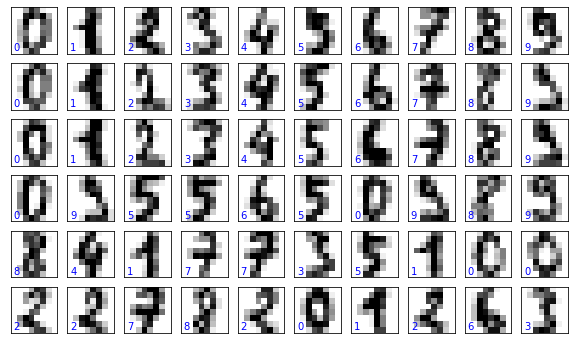

In [6]:
plt.figure(figsize = (10, 6))
for i_subplot in range(60):
    plt.subplot(6, 10, i_subplot + 1)
    draw_digit(X[i_subplot, :], y[i_subplot])

### Разбиваем данные на обучающую и тестовую выборки

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 7)
N_test, _ = X_test.shape

### Обучаем классификатор

In [8]:
from sklearn.neural_network import MLPClassifier

In [9]:
mlp_model = MLPClassifier(hidden_layer_sizes = (100,),
                          solver = 'lbfgs', 
                          activation = 'logistic',
                          random_state = 42)

In [10]:
%%time
mlp_model.fit(X_train, y_train)

CPU times: user 435 ms, sys: 304 ms, total: 739 ms
Wall time: 142 ms


MLPClassifier(activation='logistic', random_state=42, solver='lbfgs')

### Теперь можем классифицировать:

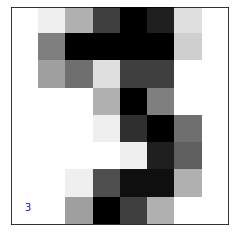

In [11]:
No = 42
Img = X_test[No, :]
dig = y_test[No]
draw_digit(Img, dig)

In [12]:
mlp_model.predict([Img])

array([3])

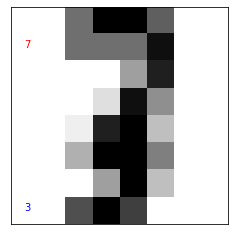

In [13]:
No = 92
Img = X_test[No, :]
dig = y_test[No]
dig_pred = mlp_model.predict([Img])[0]
draw_digit(Img, dig, dig_pred)

### Проверяем качество классификатора

In [14]:
y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)

**Ошибки на обучающей и тестовой выборках:**

In [15]:
print(np.mean(y_train != y_train_pred), np.mean(y_test != y_test_pred))

0.0 0.05387205387205387


**Можно так:**

In [16]:
print(mlp_model.score(X_train, y_train), mlp_model.score(X_test, y_test))

1.0 0.9461279461279462


In [17]:
print(1 - mlp_model.score(X_test, y_test))

0.05387205387205385


**А можно так:**

In [18]:
from sklearn.metrics import accuracy_score

In [19]:
accuracy_score(y_train, y_train_pred)

1.0

In [20]:
accuracy_score(y_test, y_test_pred)

0.9461279461279462

### Подбор _гипер_параметров

Подберем _оптимальное_ значение параметра регуляризации `alpha`

(Можно вместо циклов, написанных руками, использовать `sklearn.model_selection.GridSearchCV` и т.п.)

In [21]:
alpha_arr = np.logspace(-3, 2, 21)
test_err = []
train_err = []
train_acc = []
test_acc = []

for alpha in alpha_arr:
    mlp_model = MLPClassifier(alpha = alpha, hidden_layer_sizes = (100,), 
                              solver = 'lbfgs', activation = 'logistic', max_iter=1000, random_state = 42)
    mlp_model.fit(X_train, y_train)

    y_train_pred = mlp_model.predict(X_train)
    y_test_pred = mlp_model.predict(X_test)
    
    train_err.append(np.mean(y_train != y_train_pred))
    test_err.append(np.mean(y_test != y_test_pred))
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))

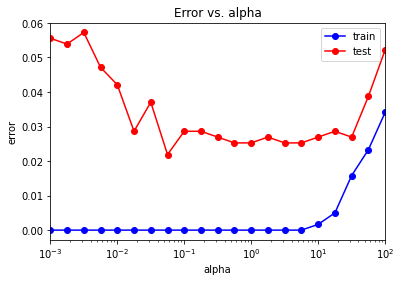

In [22]:
plt.semilogx(alpha_arr, train_err, 'b-o', label = 'train')
plt.semilogx(alpha_arr, test_err, 'r-o', label = 'test')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

**Рассмотрим как у нас менялась метрика в зависимости от гиперпараметра:**

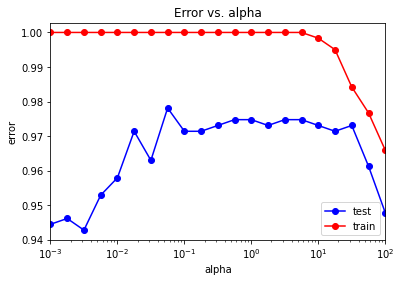

In [23]:
plt.semilogx(alpha_arr, test_acc, 'b-o', label = 'test')
plt.semilogx(alpha_arr, train_acc, 'r-o', label = 'train')
plt.xlim([np.min(alpha_arr), np.max(alpha_arr)])
plt.title('Error vs. alpha')
plt.xlabel('alpha')
plt.ylabel('error')
plt.legend()

Минимальное значение ошибки:

In [24]:
min_train_err = np.min(train_err)
min_test_err = np.min(test_err)
print(min_train_err, min_test_err)

0.0 0.021885521885521887


Оптимальное значение `alpha`:

In [25]:
alpha_opt = alpha_arr[test_err == min_test_err]
print(alpha_opt)

[0.05623413]


In [26]:
alpha_opt = alpha_opt[0]

### Классификатор при найденном _оптимальном_ значении `alpha`:

Повторим обучение:

In [27]:
mlp_model = MLPClassifier(alpha = alpha_opt, hidden_layer_sizes = (100,),
                          solver = 'lbfgs', activation = 'logistic', random_state = 42)
mlp_model.fit(X_train, y_train)

y_train_pred = mlp_model.predict(X_train)
y_test_pred = mlp_model.predict(X_test)
print(np.mean(y_train != y_train_pred))
print(np.mean(y_test != y_test_pred))

0.0
0.021885521885521887


### Матрица рассогласования:

In [28]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test_pred, y_test))

[[62  0  0  0  0  0  0  0  0  0]
 [ 0 57  0  0  0  0  0  0  2  0]
 [ 0  0 57  0  0  0  0  0  0  0]
 [ 0  0  0 54  0  0  0  0  0  0]
 [ 1  0  0  0 63  0  1  0  0  0]
 [ 0  0  0  2  0 51  0  0  1  2]
 [ 0  0  0  0  0  0 55  0  1  0]
 [ 0  0  0  0  1  0  0 58  1  0]
 [ 0  0  0  0  0  0  0  0 64  0]
 [ 0  0  0  1  0  0  0  0  0 60]]


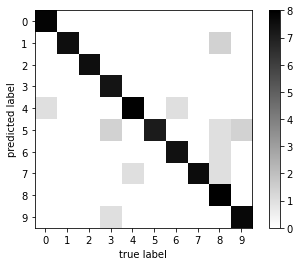

In [29]:
M = confusion_matrix(y_test_pred, y_test)
M = np.sqrt(M)
plt.imshow(M, interpolation = 'nearest')
plt.set_cmap('binary')
plt.xticks(range(10))
plt.yticks(range(10))
plt.xlabel("true label")
plt.ylabel("predicted label")
plt.colorbar()
pass

**Кроме того, вы можете воспользоваться встроенной в Sklearn [функцией](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html), которая сама считает и отрисовывает Confusion matrix**

In [30]:
from sklearn.metrics import plot_confusion_matrix

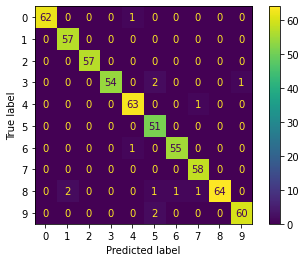

In [31]:
plot_confusion_matrix(mlp_model, X_test, y_test) 

### Другие метрики качества:

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        63
           1       0.97      1.00      0.98        57
           2       1.00      1.00      1.00        57
           3       1.00      0.95      0.97        57
           4       0.97      0.98      0.98        64
           5       0.91      1.00      0.95        51
           6       0.98      0.98      0.98        56
           7       0.97      1.00      0.98        58
           8       1.00      0.93      0.96        69
           9       0.98      0.97      0.98        62

    accuracy                           0.98       594
   macro avg       0.98      0.98      0.98       594
weighted avg       0.98      0.98      0.98       594



${\rm error} = \frac{{\rm FP} + {\rm FN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}}$ 

${\rm accuracy} = \frac{{\rm TP} + {\rm TN}}{{\rm TP} + {\rm TN} + {\rm FP} + {\rm FN}} = 1 - {\rm error}$ 

${\rm precision} = \frac{{\rm TP}}{{\rm FP}+{\rm TP}}$ 

$F_1 = 2\cdot\frac{{\rm precision}\cdot{\rm recall}}{{\rm precision}+{\rm recall}}$ 





### Все ошибки:

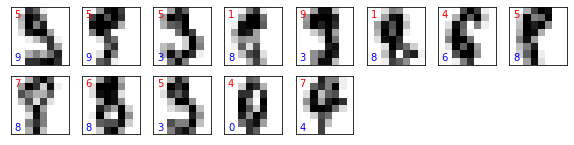

In [33]:
plt.figure(figsize = (10, 10))
i_subplot = 1 
for i in range(N_test):
    Img = X_test[i, :]
    dig = y_test[i]
    dig_pred = mlp_model.predict([Img])[0]
    if dig_pred != dig:
        plt.subplot(8, 8, i_subplot)
        draw_digit(Img, dig, dig_pred)
        i_subplot += 1